In [1]:
import pandas as pd
df = pd.read_csv("wnba_clean.csv")

In [2]:
df

,shot_type,made_shot,shot_value,coordinate_x,coordinate_y,shooting_team,home_score,away_score,qtr,quarter_seconds_remaining,game_seconds_remaining,distance,shot_group,shooting_team_encoded,shot_type_encoded,shot_group_encoded
0,Jump Shot,False,0,12,9,Indiana,0,0,1,571,2371,1.500000e+01,Jump Shot,4,34,3
1,Turnaround Bank Jump Shot,False,0,-13,0,Washington,0,0,1,551,2351,1.300000e+01,Jump Shot,13,53,3
2,Cutting Layup Shot,True,2,4,2,Indiana,0,2,1,538,2338,4.472136e+00,Layup,4,3,4
3,Driving Layup Shot,True,2,-3,0,Washington,2,2,1,524,2324,3.000000e+00,Layup,13,10,4
4,Jump Shot,True,3,-16,21,Indiana,2,5,1,512,2312,2.640076e+01,Jump Shot,4,34,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41492,Turnaround Fade Away Jump Shot,False,0,23,5,Connecticut,71,77,4,24,24,2.353720e+01,Jump Shot,2,54,3
41493,Jump Shot,False,0,-23,3,Connecticut,71,77,4,19,19,2.319483e+01,Jump Shot,2,34,3
41494,Free Throw - 1 of 2,False,0,-214748365,-214748365,Las Vegas,71,77,4,16,16,3.037001e+08,Free Throw,5,16,1
41495,Free Throw - 2 of 2,True,1,-214748365,-214748365,Las Vegas,71,78,4,16,16,3.037001e+08,Free Throw,5,18,1


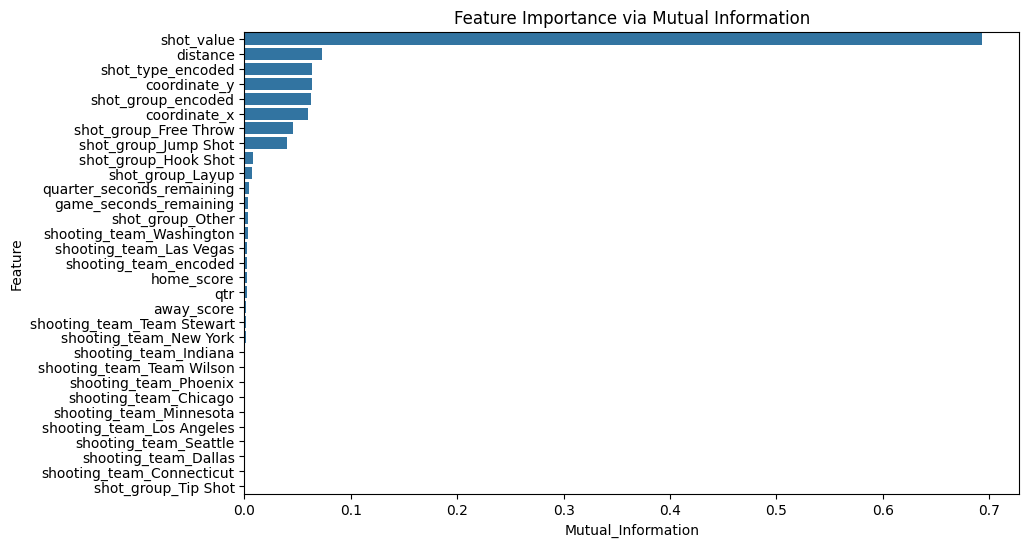

In [10]:
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
import matplotlib.pyplot as plt

target = "made_shot"
# Assuming 'target' is your target column
X = df.drop(columns=[target,"shot_type"])
y = df[target]

# Step 1: Encode categorical features (if any)
X_encoded = pd.get_dummies(X, drop_first=True)

# Step 2: Compute Mutual Information
mi_scores = mutual_info_classif(X_encoded, y, random_state=42)

# Step 3: Create a DataFrame for visualization
mi_df = pd.DataFrame({'Feature': X_encoded.columns, 'Mutual_Information': mi_scores})
mi_df = mi_df.sort_values(by='Mutual_Information', ascending=False)

# Step 4: Plot the MI scores
plt.figure(figsize=(10, 6))
sns.barplot(data=mi_df, x='Mutual_Information', y='Feature')
plt.title('Feature Importance via Mutual Information')
plt.show()


In [ ]:
# Import libraries
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import shap
import matplotlib.pyplot as plt

# Load your dataset (replace 'your_dataframe' with the actual dataframe variable)
target = "made_shot"  # Define the target column

# Step 1: Prepare Features and Target
X = df.drop(columns=[target,"shot_type","shot_value"])
y = df[target]

# Step 2: Identify Categorical Columns
categorical_columns = X.select_dtypes(include=['object', 'category', 'bool']).columns
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns

# Step 3: One-Hot Encode Categorical Columns
ohe = OneHotEncoder(drop="first", sparse_output=False)
X_categorical_encoded = ohe.fit_transform(X[categorical_columns])

# Convert encoded data into a DataFrame with feature names
categorical_feature_names = ohe.get_feature_names_out(categorical_columns)
X_categorical_encoded = pd.DataFrame(X_categorical_encoded, columns=categorical_feature_names)

# Combine Encoded Categorical Columns with Numeric Columns
X_encoded = pd.concat([X[numeric_columns].reset_index(drop=True), X_categorical_encoded.reset_index(drop=True)], axis=1)

# Step 4: Split Data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Step 5: Train a Random Forest Model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Step 6: Explain Predictions with SHAP
explainer = shap.Explainer(rf_model, X_train)  # Initialize SHAP Explainer
shap_values = explainer(X_train)              # Compute SHAP values

# Step 7: Visualize SHAP Values for Positive Class (class 1)
shap_values_class1 = shap_values[..., 1]  # Select SHAP values for class 1

# SHAP Summary Plot
shap.summary_plot(shap_values_class1, X_train)

# SHAP Bar Plot
shap.summary_plot(shap_values_class1, X_train, plot_type="bar")


/Users/rafaelconceicao/opt/anaconda3/envs/TAAC/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  1%|                   | 412/58094 [00:45<105:00]       

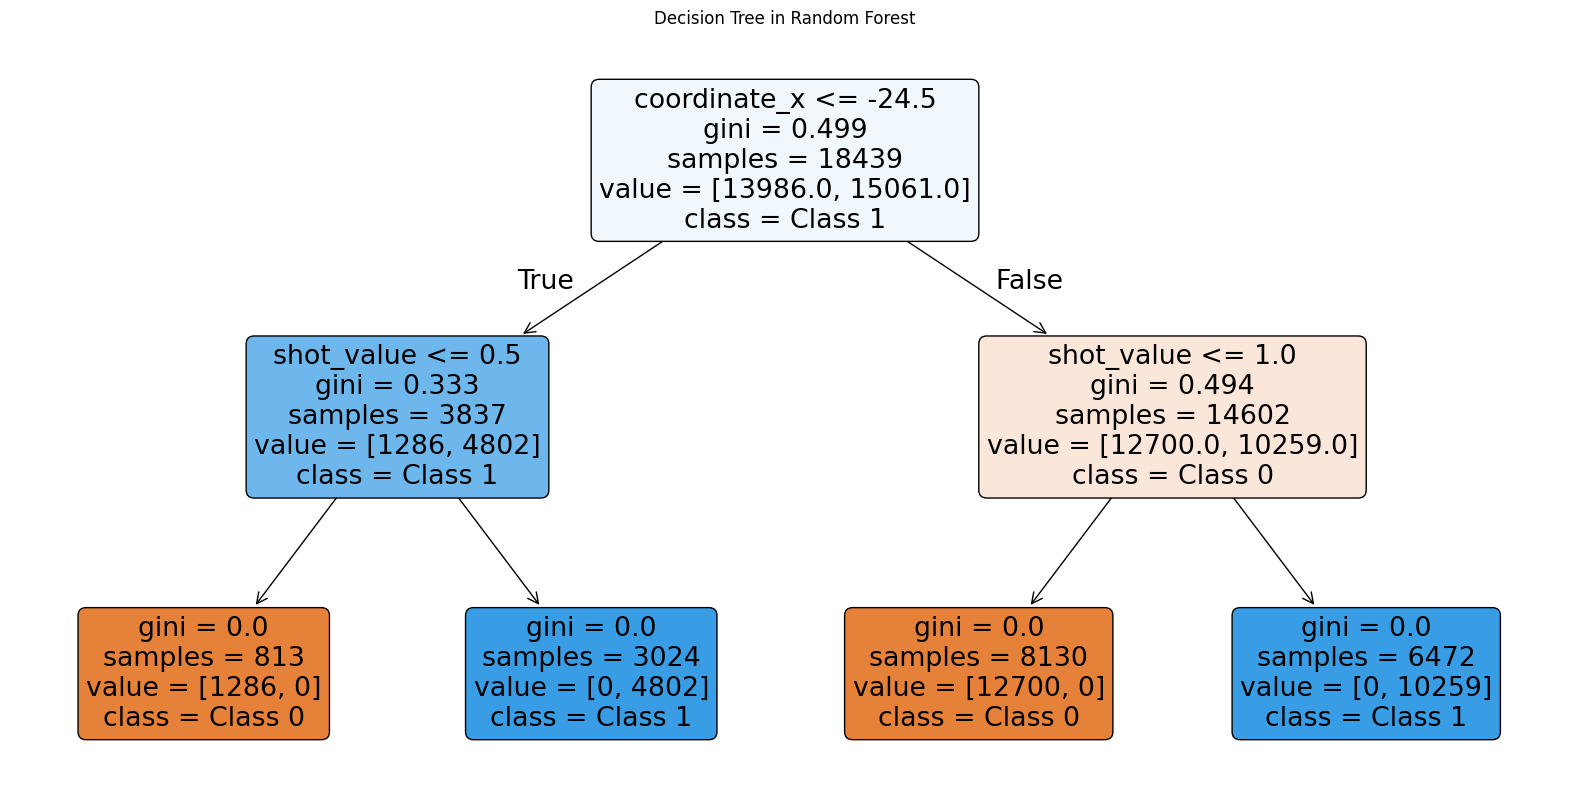

In [15]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Plot a single tree from the Random Forest
plt.figure(figsize=(20, 10))  # Adjust size for better readability
plot_tree(rf_model.estimators_[0],  # Visualize the first tree
          feature_names=X_train.columns,  # Use your training features
          class_names=["Class 0", "Class 1"],  # Replace with actual class names if necessary
          filled=True, 
          rounded=True)
plt.title("Decision Tree in Random Forest")
plt.show()


Accuracy: 1.00

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      6030
        True       1.00      1.00      1.00      6420

    accuracy                           1.00     12450
   macro avg       1.00      1.00      1.00     12450
weighted avg       1.00      1.00      1.00     12450


Confusion Matrix:
[[6030    0]
 [   0 6420]]


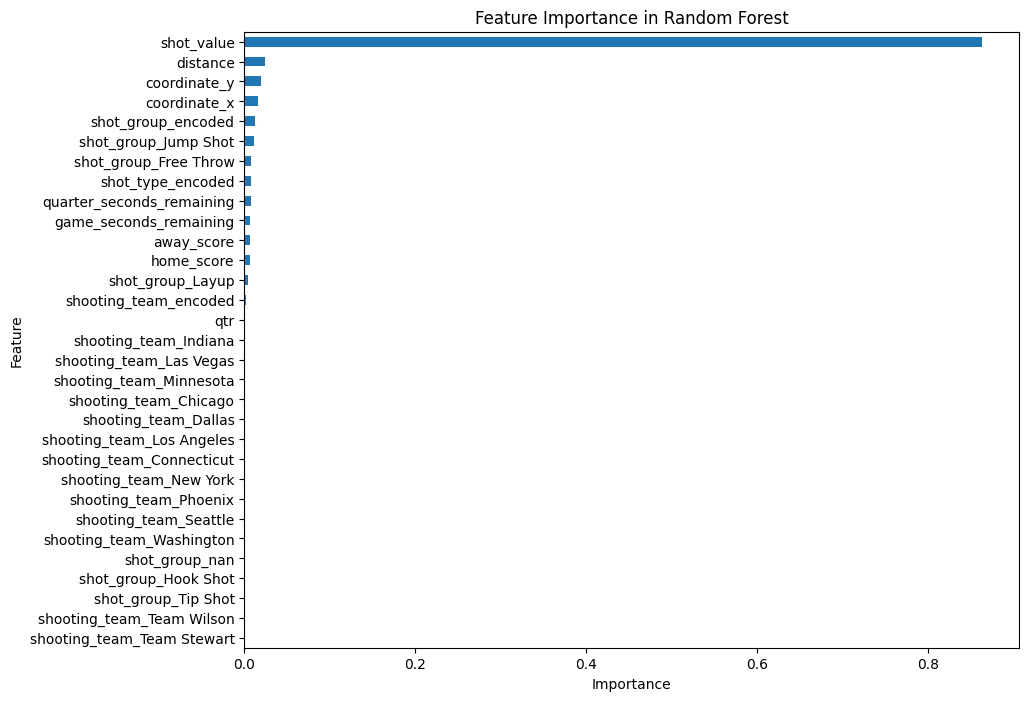

In [7]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
# Import libraries
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

# Load your dataset (replace 'your_dataframe' with the actual dataframe variable)
target = "made_shot"  # Define the target column

# Step 1: Prepare Features and Target
X = df.drop(columns=[target,"shot_type"])
y = df[target]

# Step 2: Identify Categorical Columns
categorical_columns = X.select_dtypes(include=['object', 'category', 'bool']).columns
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns

# Step 3: One-Hot Encode Categorical Columns
ohe = OneHotEncoder(drop="first", sparse_output=False)
X_categorical_encoded = ohe.fit_transform(X[categorical_columns])

# Convert encoded data into a DataFrame with feature names
categorical_feature_names = ohe.get_feature_names_out(categorical_columns)
X_categorical_encoded = pd.DataFrame(X_categorical_encoded, columns=categorical_feature_names)

# Combine Encoded Categorical Columns with Numeric Columns
X_encoded = pd.concat([X[numeric_columns].reset_index(drop=True), X_categorical_encoded.reset_index(drop=True)], axis=1)

# Step 4: Split Data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Step 5: Train a Random Forest Model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
# Step 1: Evaluate Model Performance
# Predict on the test set
y_pred = rf_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Step 2: Visualize Feature Importance
# Get feature importances from the Random Forest
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)

# Filter for non-zero importance (optional)
importances = importances[importances > 0]

# Plot feature importances
importances.sort_values().plot(kind='barh', figsize=(10, 8))
plt.title("Feature Importance in Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()
